In [1]:
import os
import mlflow
import pandas as pd
import psycopg
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, log_loss
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from autofeat import AutoFeatClassifier


In [2]:
os.environ["DB_DESTINATION_HOST"] = os.getenv("DB_DESTINATION_HOST")
os.environ["DB_DESTINATION_PORT"] = os.getenv("DB_DESTINATION_PORT")
os.environ["DB_DESTINATION_NAME"] = os.getenv("DB_DESTINATION_NAME")
os.environ["DB_DESTINATION_USER"] = os.getenv("DB_DESTINATION_USER")
os.environ["DB_DESTINATION_PASSWORD"] = os.getenv("DB_DESTINATION_PASSWORD")

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") # получаем ключ бакета, к которому подключён MLFlow, из .env

# определяем глобальные переменные
# поднимаем MLflow локально
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000


registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)

# название тестового эксперимента и запуска (run) внутри него
EXPERIMENT_NAME = "real_churn_Andrey"
RUN_NAME = "feature_selection_sbs"
REGISTRY_MODEL_NAME = "real_churn_model_Andrey"
FS_ASSETS = "fs_assets" 


In [3]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.environ["DB_DESTINATION_HOST"], 
    "port": os.environ["DB_DESTINATION_PORT"],
    "dbname": os.environ["DB_DESTINATION_NAME"],
    "user": os.environ["DB_DESTINATION_USER"],
    "password": os.environ["DB_DESTINATION_PASSWORD"],
}
assert all([var_value != "" for var_value in list(postgres_credentials.values())])

connection.update(postgres_credentials)

# определим название таблицы, в которой хранятся наши данные.
TABLE_NAME = "clean_users_churn"

# эта конструкция создаёт контекстное управление для соединения с базой данных 
# оператор with гарантирует, что соединение будет корректно закрыто после выполнения всех операций 
# закрыто оно будет даже в случае ошибки, чтобы не допустить "утечку памяти"
with psycopg.connect(**connection) as conn:

# создаёт объект курсора для выполнения запросов к базе данных
# с помощью метода execute() выполняется SQL-запрос для выборки данных из таблицы TABLE_NAME
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
                
                # извлекаем все строки, полученные в результате выполнения запроса
        data = cur.fetchall()

                # получает список имён столбцов из объекта курсора
        columns = [col[0] for col in cur.description]

# создаёт объект DataFrame из полученных данных и имён столбцов. 
# это позволяет удобно работать с данными в Python, используя библиотеку Pandas.
df = pd.DataFrame(data, columns=columns)

In [4]:
df

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,...,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,14,5918-VUKWP,2017-06-01,NaT,One year,No,Bank transfer (automatic),20.55,654.55,Fiber optic,...,No,No,No,No,Female,0,No,No,No,0
1,15,1744-JHKYS,2017-04-01,NaT,Month-to-month,No,Electronic check,24.70,780.20,Fiber optic,...,No,No,No,No,Female,0,Yes,No,Yes,0
2,16,2984-RGEYA,2014-05-01,NaT,Two year,No,Bank transfer (automatic),19.75,1375.40,Fiber optic,...,No,No,No,No,Female,0,Yes,Yes,No,0
3,17,9680-NIAUV,2014-02-01,NaT,Two year,No,Credit card (automatic),109.70,8129.30,Fiber optic,...,Yes,No,Yes,Yes,Female,0,Yes,Yes,Yes,0
4,18,2146-EGVDT,2015-03-01,NaT,Two year,No,Credit card (automatic),19.30,1192.70,Fiber optic,...,No,No,No,No,Male,0,Yes,Yes,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7014,7015,6502-MJQAE,2019-11-01,2019-12-01,Month-to-month,Yes,Electronic check,69.60,69.60,Fiber optic,...,No,No,No,No,Male,0,No,No,No,1
7015,7016,6257-DTAYD,2014-03-01,NaT,Two year,Yes,Credit card (automatic),104.15,7365.30,Fiber optic,...,No,Yes,Yes,Yes,Male,0,Yes,No,Yes,0
7016,7017,4616-ULAOA,2014-09-01,NaT,Two year,Yes,Credit card (automatic),110.80,7245.90,Fiber optic,...,Yes,Yes,Yes,Yes,Female,0,Yes,Yes,Yes,0
7017,7018,7693-LCKZL,2019-05-01,2019-10-01,Month-to-month,Yes,Electronic check,80.15,385.00,Fiber optic,...,No,No,No,No,Male,0,Yes,Yes,Yes,1


In [5]:
#import joblib
#with open('model_churn/fitted_model.pkl', 'rb') as f:
#        model=joblib.load(f)

In [6]:
split_column = "begin_date"
test_size = 0.2

cat_features = [
    'paperless_billing',
    'payment_method',
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies',
    'gender',
    'senior_citizen',
    'partner',
    'dependents',
    'multiple_lines',
]
num_features = ["monthly_charges", "total_charges"]
target = ['target']

features = cat_features + num_features

df = df.sort_values(by=[split_column])

X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df[target],
    test_size=test_size,
    shuffle=False,
) 

transformations = ('1/', 'log', 'abs', 'sqrt')

afc = AutoFeatClassifier(categorical_cols=cat_features, transformations=transformations, feateng_steps=1, n_jobs=-1)

X_train_features = afc.fit_transform(X_train,  y_train)
X_test_features = afc.transform(X_test)

/home/andrey/work/MLE/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
estimator = RandomForestClassifier(n_estimators=300)


sfs = SFS(estimator,
    k_features=10,       
    forward=True,      
    floating=False,     
    scoring='roc_auc', 
    cv=4,               
    n_jobs=-1
)
sbs = SFS(estimator,
    k_features=10,       
    forward=False,      
    floating=False,     
    scoring='roc_auc', 
    cv=4,               
    n_jobs=-1
         )
sfs = sfs.fit(X_train_features, y_train)
sbs = sbs.fit(X_train_features, y_train)

top_sfs = sfs.k_feature_names_
top_sbs = sbs.k_feature_names_

print('\nSequential Forward Selection (k=10)')
print('CV Score:')
print(sfs.k_score_)

print('\nSequential Backward Selection')
print('CV Score:')
print(sbs.k_score_)

/home/andrey/work/MLE/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/andrey/work/MLE/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/andrey/work/MLE/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/andrey/work/MLE/mle-mlflow/.venv_mlflow/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s


Sequential Forward Selection (k=10)
CV Score:
0.7494390142059684

Sequential Backward Selection
CV Score:
0.7420924291721196


In [13]:
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T 

In [14]:
sbs_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
33,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.6738254830917875, 0.4753864734299517, 0.522...",0.616549,"(monthly_charges, total_charges, cat_paperless...",0.202245,0.126168,0.072843
32,"(0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.7334027777777778, 0.6237741545893722, 0.661...",0.703848,"(monthly_charges, cat_paperless_billing_No, ca...",0.106806,0.06663,0.038469
31,"(0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.7569836956521739, 0.7474094202898551, 0.747...",0.744775,"(monthly_charges, cat_paperless_billing_No, ca...",0.017698,0.011041,0.006374
30,"(0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.7603381642512078, 0.752199577294686, 0.7510...",0.74829,"(monthly_charges, cat_paperless_billing_No, ca...",0.018245,0.011382,0.006571
29,"(0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.7598112922705313, 0.7541908212560386, 0.750...",0.750326,"(monthly_charges, cat_paperless_billing_No, ca...",0.013471,0.008404,0.004852
28,"(0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.7596557971014494, 0.7549788647342995, 0.754...",0.750349,"(monthly_charges, cat_paperless_billing_No, ca...",0.016812,0.010488,0.006055
27,"(0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.757626811594203, 0.760018115942029, 0.75662...",0.751557,"(monthly_charges, cat_paperless_billing_No, ca...",0.018247,0.011383,0.006572
26,"(0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.7577309782608695, 0.7606748188405796, 0.756...",0.752641,"(monthly_charges, cat_paperless_billing_No, ca...",0.01588,0.009906,0.005719
25,"(0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.7609103260869565, 0.7616485507246378, 0.761...",0.754831,"(monthly_charges, cat_paperless_billing_No, ca...",0.017864,0.011145,0.006434
24,"(0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[0.7567904589371981, 0.763268417874396, 0.7629...",0.754862,"(monthly_charges, cat_paperless_billing_No, ca...",0.017556,0.010952,0.006323


In [15]:
os.mkdir(FS_ASSETS)

sfs_df.to_csv(f"{FS_ASSETS}/sfs.csv")
sbs_df.to_csv(f"{FS_ASSETS}/sbs.csv") 

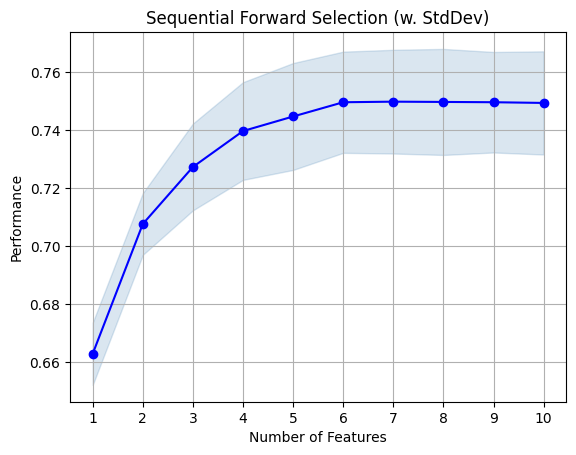

<Figure size 640x480 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
#from mlxtend.plotting import plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sfs.png") 

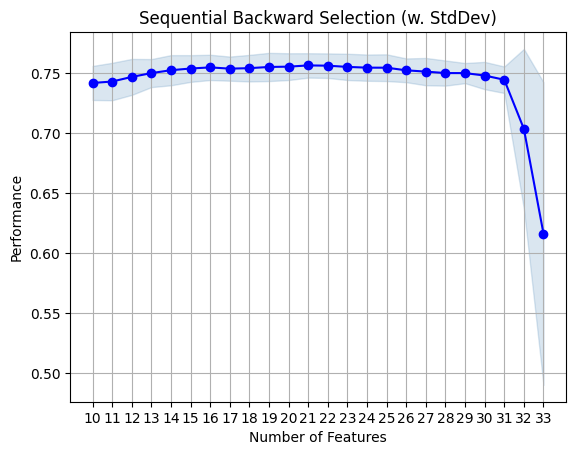

<Figure size 640x480 with 0 Axes>

In [23]:

fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS}/sbs.png")

In [24]:
interc_features = list(set(top_sbs) & set(top_sfs))
union_features = list(set(top_sbs) | set(top_sfs))

In [30]:
interc_features

['cat_partner_No',
 'cat_payment_method_Electronic check',
 'cat_paperless_billing_No',
 'cat_senior_citizen_0',
 'cat_internet_service_DSL']

In [26]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=f"{RUN_NAME}_intersection_and_union", experiment_id=experiment_id) as run:
    run_id = run.info.run_id
   
    mlflow.log_artifacts(FS_ASSETS) 

In [33]:
X_train_features_interc = X_train_features.loc[:,interc_features]
X_train_features_union = X_train_features.loc[:,union_features]
X_test_features_interc = X_test_features.loc[:,interc_features]
X_test_features_union = X_test_features.loc[:,union_features]

In [34]:
model_interc = CatBoostClassifier()
model_interc.fit(X_train_features_interc, y_train)
prediction_interc = model_interc.predict(X_test_features_interc)

Learning rate set to 0.021523
0:	learn: 0.6813578	total: 1.24ms	remaining: 1.23s
1:	learn: 0.6710499	total: 2.13ms	remaining: 1.06s
2:	learn: 0.6600175	total: 2.85ms	remaining: 948ms
3:	learn: 0.6493345	total: 3.63ms	remaining: 904ms
4:	learn: 0.6400944	total: 4.34ms	remaining: 864ms
5:	learn: 0.6316778	total: 5ms	remaining: 828ms
6:	learn: 0.6233314	total: 5.67ms	remaining: 805ms
7:	learn: 0.6153654	total: 6.4ms	remaining: 793ms
8:	learn: 0.6078593	total: 7.11ms	remaining: 783ms
9:	learn: 0.6003274	total: 7.85ms	remaining: 777ms
10:	learn: 0.5938239	total: 8.53ms	remaining: 767ms
11:	learn: 0.5867044	total: 9.34ms	remaining: 769ms
12:	learn: 0.5806055	total: 10ms	remaining: 762ms
13:	learn: 0.5751259	total: 10.7ms	remaining: 755ms
14:	learn: 0.5693051	total: 11.4ms	remaining: 751ms
15:	learn: 0.5630023	total: 12.4ms	remaining: 760ms
16:	learn: 0.5583259	total: 13.1ms	remaining: 755ms
17:	learn: 0.5530370	total: 13.9ms	remaining: 756ms
18:	learn: 0.5480218	total: 14.7ms	remaining: 759m

In [35]:
model_union = CatBoostClassifier()
model_union.fit(X_train_features_union, y_train)
prediction_union = model_union.predict(X_test_features_union)

Learning rate set to 0.021523
0:	learn: 0.6781046	total: 1.69ms	remaining: 1.68s
1:	learn: 0.6654189	total: 2.93ms	remaining: 1.46s
2:	learn: 0.6525866	total: 4.18ms	remaining: 1.39s
3:	learn: 0.6427756	total: 5.13ms	remaining: 1.28s
4:	learn: 0.6306721	total: 6.4ms	remaining: 1.27s
5:	learn: 0.6187399	total: 7.69ms	remaining: 1.27s
6:	learn: 0.6090960	total: 9.02ms	remaining: 1.28s
7:	learn: 0.5996141	total: 10.3ms	remaining: 1.28s
8:	learn: 0.5895771	total: 11.8ms	remaining: 1.29s
9:	learn: 0.5816684	total: 13.2ms	remaining: 1.31s
10:	learn: 0.5724947	total: 14.5ms	remaining: 1.3s
11:	learn: 0.5659268	total: 15.6ms	remaining: 1.28s
12:	learn: 0.5579007	total: 16.9ms	remaining: 1.28s
13:	learn: 0.5504047	total: 18.2ms	remaining: 1.28s
14:	learn: 0.5427709	total: 19.5ms	remaining: 1.28s
15:	learn: 0.5378002	total: 20.8ms	remaining: 1.28s
16:	learn: 0.5319011	total: 22.1ms	remaining: 1.28s
17:	learn: 0.5256806	total: 23.5ms	remaining: 1.28s
18:	learn: 0.5208325	total: 25ms	remaining: 1.

In [36]:

from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, log_loss
# импортируйте необходимые вам модули
def make_metrics(y_test, prediction):
    metrics = {}

    # посчитайте метрики из модуля sklearn.metrics
    # err_1 — ошибка первого рода
    # err_2 — ошибка второго рода
    _, err1, err2, _ = confusion_matrix(y_test, prediction,normalize='all').ravel()
    #auc = roc_auc_score(y_test, probas)
    precision = precision_score(y_test, prediction)
    recall = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    logloss = log_loss(y_test, prediction)

    # запишите значения метрик в словарь
    metrics["err1"] = err1
    metrics["err2"] = err2
    #metrics["auc"] = auc
    metrics["precision"] = precision
    metrics["recall"] = recall
    metrics["f1"] = f1
    metrics["logloss"] = logloss
    
    return metrics

metrics_interc = make_metrics(y_test, prediction_interc)
metrics_union = make_metrics(y_test, prediction_union)


In [10]:
"""
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
metrics={}

metrics["mae"] = mean_absolute_error(y_test, prediction)
metrics["mape"] = mean_absolute_percentage_error(y_test, prediction)
"""

'\nfrom sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error\nmetrics={}\n\nmetrics["mae"] = mean_absolute_error(y_test, prediction)\nmetrics["mape"] = mean_absolute_percentage_error(y_test, prediction)\n'

In [37]:

pip_requirements = "requirements.txt"
signature_u = mlflow.models.infer_signature(X_train_features_union, prediction_union)
input_example_u = X_train_features_union[:10]
metadata =  {'model_type': 'churn_month'}

pip_requirements = "requirements.txt"
signature_i= mlflow.models.infer_signature(X_train_features_union, prediction_union)
input_example_i = X_train_features_union[:10]
metadata =  {'model_type': 'churn_month'}

artifact_path = "model"


In [40]:



experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

if not experiment_id:
        experiment_id = mlflow.create_experiment(EXPERIMENT_NAME) # ваш код здесь

with mlflow.start_run(run_name='Union_sbs', experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id # ваш код здесь
    
    model_info = mlflow.catboost.log_model( 
			cb_model=model_union,
            pip_requirements=pip_requirements,
            signature=signature_u,
            input_example=input_example_u,
            metadata=metadata,
            #code_path=code_paths,
            await_registration_for=60,
            artifact_path=artifact_path,
            registered_model_name="churn_model_union_intersec")

    mlflow.log_metrics(metrics_union) 

    afc_info = mlflow.sklearn.log_model(afc, artifact_path=artifact_path) 
    
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
# получаем данные о запуске эксперимента по его уникальному идентификатору
run = mlflow.get_run(run_id) # ваш код здесь


# проверяем, что статус запуска эксперимента изменён на 'FINISHED'
# это утверждение (assert) можно использовать для автоматической проверки того, 
# что эксперимент был завершён успешно
assert (run.info.status =='FINISHED')# ваш код здесь

# удаляем файлы 'columns.txt' и 'users_churn.csv' из файловой системы,
# чтобы очистить рабочую среду после логирования артефактов
#os.remove('columns.txt') # ваш код здесь
#os.remove('users_churn.csv') # ваш код здесьcsv

Successfully registered model 'churn_model_union_intersec'.
2024/04/10 17:53:00 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: churn_model_union_intersec, version 1
Created version '1' of model 'churn_model_union_intersec'.


In [41]:


experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

if not experiment_id:
        experiment_id = mlflow.create_experiment(EXPERIMENT_NAME) # ваш код здесь

with mlflow.start_run(run_name='Intersec_sbs', experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id # ваш код здесь
    
    model_info = mlflow.catboost.log_model( 
			cb_model=model_interc,
            pip_requirements=pip_requirements,
            signature=signature_i,
            input_example=input_example_i,
            metadata=metadata,
            #code_path=code_paths,
            await_registration_for=60,
            artifact_path=artifact_path,
            registered_model_name="churn_model_union_intersec")

    mlflow.log_metrics(metrics_interc) 

    afc_info = mlflow.sklearn.log_model(afc, artifact_path=artifact_path) 
    
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
# получаем данные о запуске эксперимента по его уникальному идентификатору
run = mlflow.get_run(run_id) # ваш код здесь


# проверяем, что статус запуска эксперимента изменён на 'FINISHED'
# это утверждение (assert) можно использовать для автоматической проверки того, 
# что эксперимент был завершён успешно
assert (run.info.status =='FINISHED')# ваш код здесь

# удаляем файлы 'columns.txt' и 'users_churn.csv' из файловой системы,
# чтобы очистить рабочую среду после логирования артефактов
#os.remove('columns.txt') # ваш код здесь
#os.remove('users_churn.csv') # ваш код здесьcsv

Registered model 'churn_model_union_intersec' already exists. Creating a new version of this model...
2024/04/10 17:53:15 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: churn_model_union_intersec, version 2
Created version '2' of model 'churn_model_union_intersec'.


In [4]:
client = mlflow.MlflowClient(tracking_uri=tracking_uri, registry_uri=registry_uri)


models = client.search_model_versions(
    filter_string=f"name = '{REGISTRY_MODEL_NAME}'"
)
print(f"Model info:\n {models}")

model_name_1 = models[-1].name
model_version_1 = models[-1].version
model_stage_1 = models[-1].current_stage

model_name_2 = models[-2].name
model_version_2 = models[-2].version
model_stage_2 = models[-2].current_stage


print(f"Текущий stage модели 1: {model_stage_1}")
print(f"Текущий stage модели 2: {model_stage_2}")

# поменяйте статус каждой модели
client.transition_model_version_stage(
    model_name_1, model_version_1, 'production')
client.transition_model_version_stage(
    model_name_2, model_version_2, 'staging')

# переимнуйте модель в реестре
client.rename_registered_model(
    name = REGISTRY_MODEL_NAME, new_name = f'{REGISTRY_MODEL_NAME}_b2c')

NameError: name 'mlflow' is not defined

In [18]:
print(f"Текущий stage модели 1: {model_stage_1}")
print(f"Текущий stage модели 2: {model_stage_2}")

Текущий stage модели 1: None
Текущий stage модели 2: None


In [29]:
#EXPERIMENT_NAME = "real_churn_Andrey"
client = mlflow.MlflowClient(tracking_uri=tracking_uri, registry_uri=registry_uri)


experiment_id = client.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
experiment_id

'4'

In [34]:
experiment_runs = mlflow.search_runs(
    experiment_ids=[experiment_id],
).sort_values(by="start_time", ascending=False) 
experiment_runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.precision,metrics.f1,metrics.logloss,metrics.recall,metrics.err1,metrics.err2,tags.mlflow.source.name,tags.mlflow.log-model.history,tags.mlflow.user,tags.mlflow.source.git.commit,tags.mlflow.runName,tags.mlflow.source.type
0,4b949d984942429c955db21f07f65485,4,FINISHED,s3://s3-student-mle-20240228-2fd44f5a96/4/4b94...,2024-03-29 13:26:12.248000+00:00,2024-03-29 13:26:21.986000+00:00,0.621212,0.567194,7.496258,0.521818,0.083096,0.124881,/home/andrey/work/MLE/mle-mlflow/.venv_mlflow/...,"[{""run_id"": ""4b949d984942429c955db21f07f65485""...",andrey,f9fee667dcf070cccb9686a1e443a7d487279b2e,real_churn_run,LOCAL
1,b97b26920b84410cb7bda513bd88da4f,4,FINISHED,s3://s3-student-mle-20240228-2fd44f5a96/4/b97b...,2024-03-29 13:14:38.166000+00:00,2024-03-29 13:14:47.382000+00:00,0.621212,0.567194,7.496258,0.521818,0.083096,0.124881,/home/andrey/work/MLE/mle-mlflow/.venv_mlflow/...,"[{""run_id"": ""b97b26920b84410cb7bda513bd88da4f""...",andrey,97606f259f3836476c28ba5dbee9187602029cb0,real_churn_run,LOCAL
2,4616792e05cf4bea9eb54b80389a247d,4,FINISHED,s3://s3-student-mle-20240228-2fd44f5a96/4/4616...,2024-03-29 12:58:55.597000+00:00,2024-03-29 12:59:13.866000+00:00,0.621212,0.567194,7.496258,0.521818,0.083096,0.124881,/home/andrey/work/MLE/mle-mlflow/.venv_mlflow/...,"[{""run_id"": ""4616792e05cf4bea9eb54b80389a247d""...",andrey,97606f259f3836476c28ba5dbee9187602029cb0,real_churn_run,LOCAL
3,f1108dab83ba4257b792daa42ea0aafc,4,FINISHED,s3://s3-student-mle-20240228-2fd44f5a96/4/f110...,2024-03-29 12:46:36.731000+00:00,2024-03-29 12:47:26.831000+00:00,0.650000,0.570533,7.034160,0.508380,0.069801,0.129630,/home/andrey/work/MLE/mle-mlflow/.venv_mlflow/...,"[{""run_id"": ""f1108dab83ba4257b792daa42ea0aafc""...",andrey,97606f259f3836476c28ba5dbee9187602029cb0,real_churn_run,LOCAL
4,8d3bd5cdc8ba4dd3b2df51185993ef7c,4,FINISHED,s3://s3-student-mle-20240228-2fd44f5a96/4/8d3b...,2024-03-29 12:10:05.604000+00:00,2024-03-29 12:10:20.887000+00:00,0.255532,0.407049,26.776019,1.000000,0.742877,0.254986,/home/andrey/work/MLE/mle-mlflow/.venv_mlflow/...,"[{""run_id"": ""8d3bd5cdc8ba4dd3b2df51185993ef7c""...",andrey,97606f259f3836476c28ba5dbee9187602029cb0,real_churn_run,LOCAL
5,2e4250fb78604ec19abd93c40b581f51,4,FAILED,s3://s3-student-mle-20240228-2fd44f5a96/4/2e42...,2024-03-29 12:05:24.460000+00:00,2024-03-29 12:05:26.314000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,/home/andrey/work/MLE/mle-mlflow/.venv_mlflow/...,None,andrey,97606f259f3836476c28ba5dbee9187602029cb0,real_churn_run,LOCAL
6,355e39b25e3b4798a33dd5a86bbb71ca,4,FAILED,s3://s3-student-mle-20240228-2fd44f5a96/4/355e...,2024-03-29 12:04:46.089000+00:00,2024-03-29 12:04:47.582000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,/home/andrey/work/MLE/mle-mlflow/.venv_mlflow/...,None,andrey,97606f259f3836476c28ba5dbee9187602029cb0,real_churn_run,LOCAL
7,1648c4c2f9e042989ec051cead75b4ab,4,FAILED,s3://s3-student-mle-20240228-2fd44f5a96/4/1648...,2024-03-29 12:04:32.556000+00:00,2024-03-29 12:04:33.914000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,/home/andrey/work/MLE/mle-mlflow/.venv_mlflow/...,None,andrey,97606f259f3836476c28ba5dbee9187602029cb0,real_churn_run,LOCAL
8,4670a483ca2544de96ea188f2d10461a,4,FAILED,s3://s3-student-mle-20240228-2fd44f5a96/4/4670...,2024-03-29 11:57:26.663000+00:00,2024-03-29 11:57:27.378000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,/home/andrey/work/MLE/mle-mlflow/.venv_mlflow/...,None,andrey,97606f259f3836476c28ba5dbee9187602029cb0,real_churn_run,LOCAL


In [53]:
print( '"'+ '","'.join([col for col in experiment_runs.columns if 'metric' in col])+'"')
runs = experiment_runs[[
	"run_id", "start_time", "metrics.precision","metrics.f1","metrics.logloss","metrics.recall","metrics.err1","metrics.err2"
	
]].dropna()
runs

"metrics.precision","metrics.f1","metrics.logloss","metrics.recall","metrics.err1","metrics.err2"


,run_id,start_time,metrics.precision,metrics.f1,metrics.logloss,metrics.recall,metrics.err1,metrics.err2
0,4b949d984942429c955db21f07f65485,2024-03-29 13:26:12.248000+00:00,0.621212,0.567194,7.496258,0.521818,0.083096,0.124881
1,b97b26920b84410cb7bda513bd88da4f,2024-03-29 13:14:38.166000+00:00,0.621212,0.567194,7.496258,0.521818,0.083096,0.124881
2,4616792e05cf4bea9eb54b80389a247d,2024-03-29 12:58:55.597000+00:00,0.621212,0.567194,7.496258,0.521818,0.083096,0.124881
3,f1108dab83ba4257b792daa42ea0aafc,2024-03-29 12:46:36.731000+00:00,0.650000,0.570533,7.034160,0.508380,0.069801,0.129630
4,8d3bd5cdc8ba4dd3b2df51185993ef7c,2024-03-29 12:10:05.604000+00:00,0.255532,0.407049,26.776019,1.000000,0.742877,0.254986


In [2]:

from sqlalchemy import select